# (12) rotation

**Motivation**: host = ```Any```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: chewie

In [3]:
from analysis.rotation import *


def _plot(rotation_results, which: str = 'mse_latent'):
    if which == 'mse_latent':
        num_rounds = kws['num_rounds']
        figsize_x = 2.4 * num_rounds
    else:
        num_rounds = 1
        figsize_x = 4
    fig, axes = create_figure(2, 1, figsize=(figsize_x, 5), sharex='all')
    
    d2p = rotation_results['iterative'][which]
    perf = np.mean(list(d2p.values())[1:])
    for ax in axes.flat:
        ax.axhline(perf, ls='--', color='k')

    pal = {'iterative': 'k', 'amortized': 'r'}
    for i, (name, color) in enumerate(pal.items()):
        d2p = rotation_results[name][which]
        perf = list(d2p.values())
        if which == 'mse_latent':
            perf = np.mean(perf[1:])
        else:
            perf = np.mean(perf[1:-1])
        axes[i].plot(d2p.keys(), d2p.values(), label=name, marker='o', color=color)
        axes[i].set_title(f"{name}, avg mse = {perf:0.1f}")

    for ax in axes.flat:
        ax.set(xticks=list(d2p.keys()))
        ax.tick_params(axis='x', rotation=-90)
        for i in range(num_rounds):
            ax.axvspan(
                i * 360, (i + 1) * 360,
                color=f'C{i}', alpha=0.1,
            )
    fig.suptitle(r"$\Delta \theta = $" + f"{kws['delta_theta']}", fontsize=17)
    axes[1].set_xlabel(r"$\theta$", fontsize=15)
    add_legend(axes, loc='lower center')
    add_grid(axes)
    plt.show()

## Amortized Gaussian

In [4]:
shuffle = False

model_name = 'gaussian_MNIST_t-1_z-[128]_<mlp|mlp>'
fit_name = 'amort_u:(5.0)-du:(5.0)_b200-ep500-lr(0.002)_beta(1:0x0.1)_gr(100)_(2024_09_11,22:35)'

tr, meta = load_model(model_name, fit_name, device=device, shuffle=shuffle)

In [5]:
w = tonp(tr.model.layer.dec[-1].weight.data)
w = w.T.reshape(-1, 28, 28)

w.shape

(428, 28, 28)

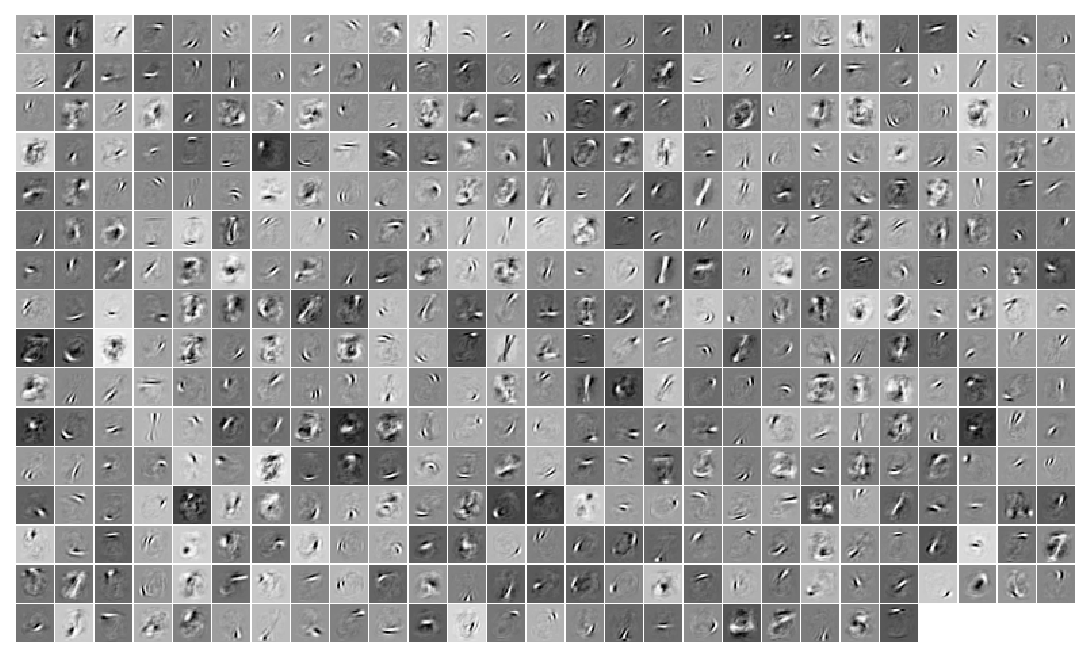

In [6]:
fig, ax = plot_weights(w, nrows=16, display=False)
fig

In [7]:
fig.savefig(pjoin(fig_base_dir, 'mlp-MNIST-gaussian-amortized.pdf'), bbox_inches='tight')

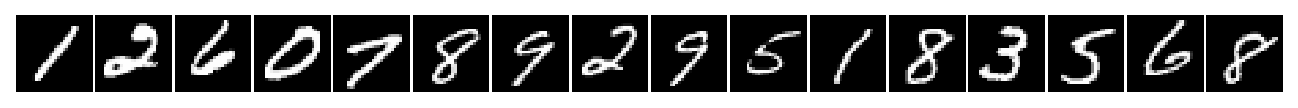

0

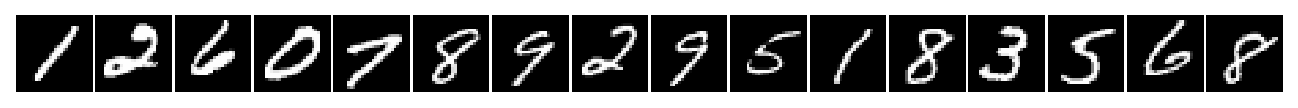

15

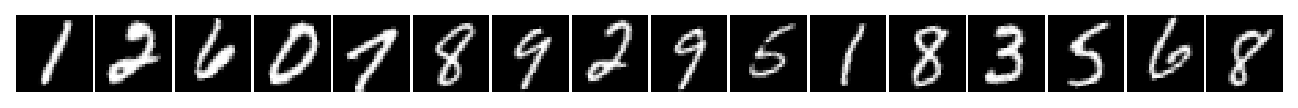

30

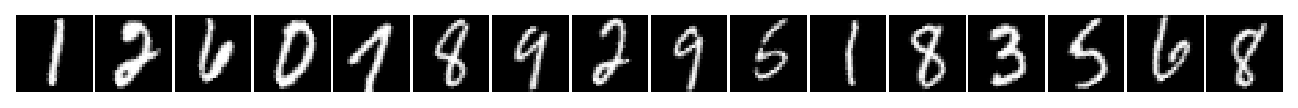

45

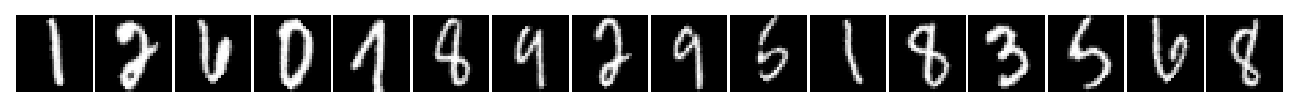

60

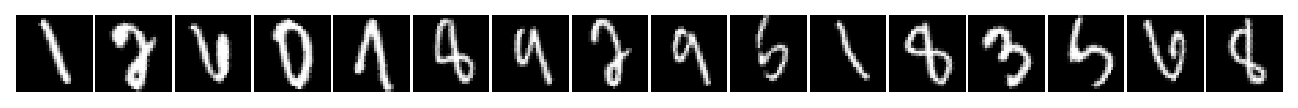

75

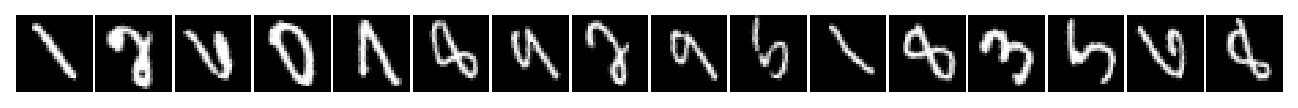

90

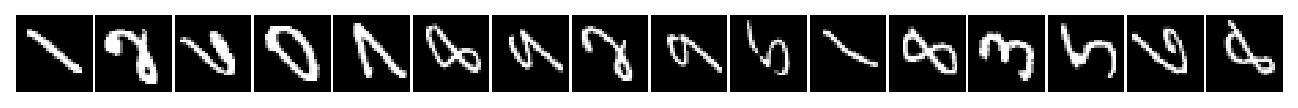

105

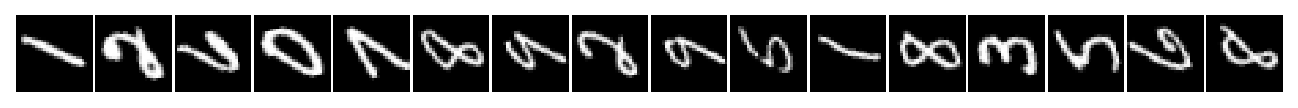

120

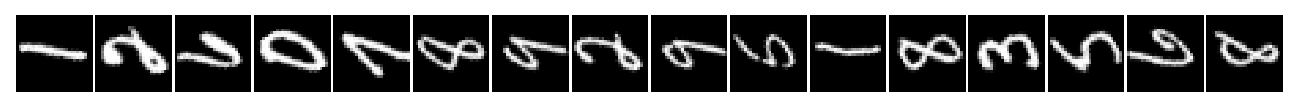

135

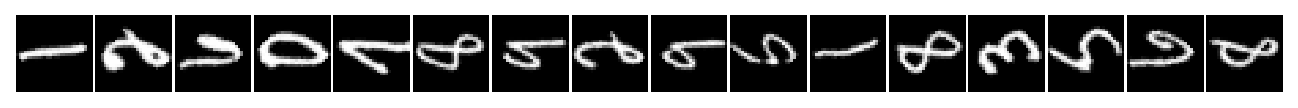

150

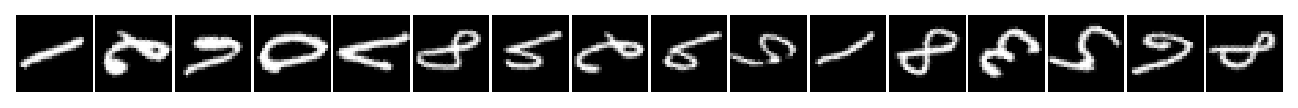

165

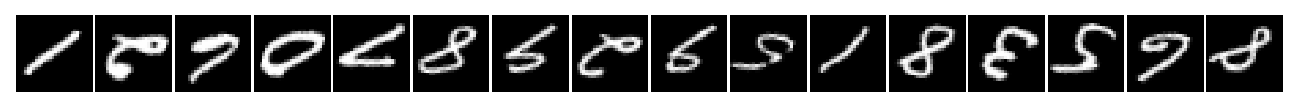

180

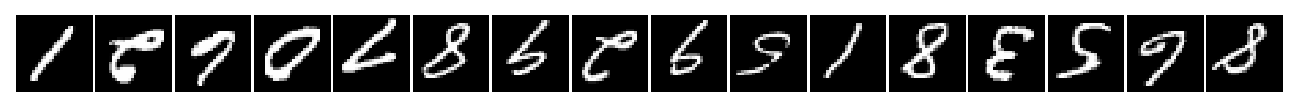

195

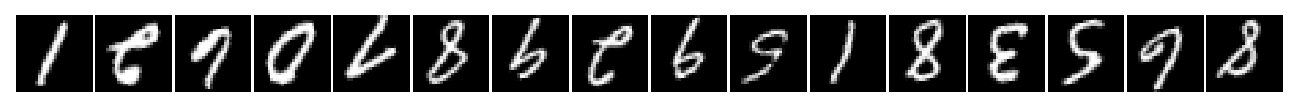

210

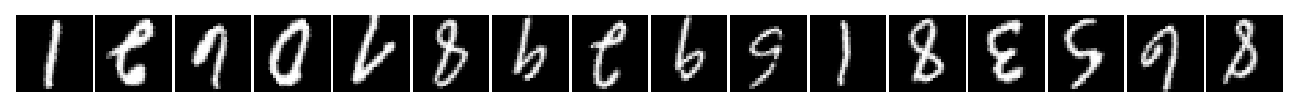

225

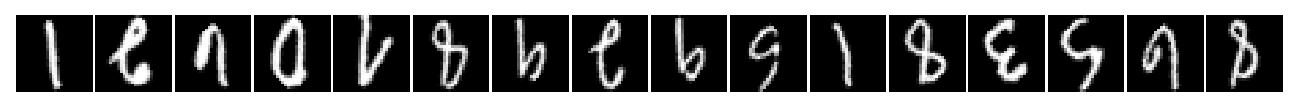

240

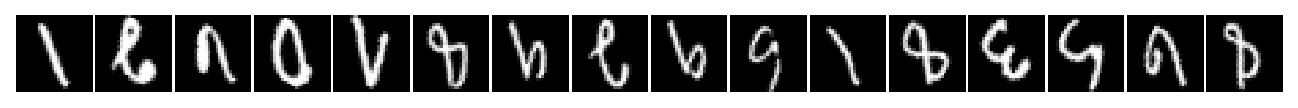

255

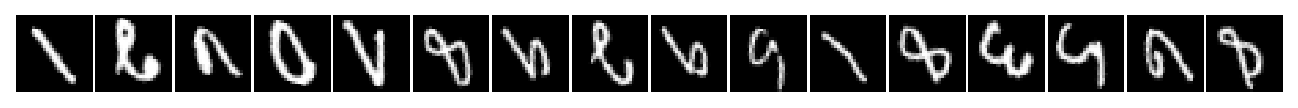

270

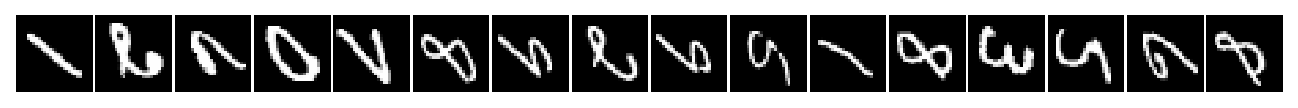

285

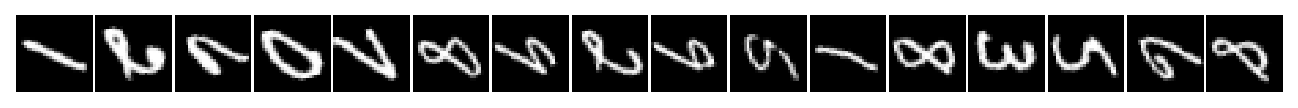

300

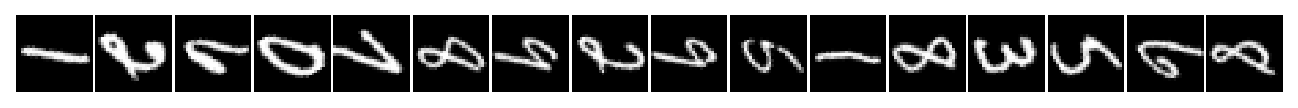

315

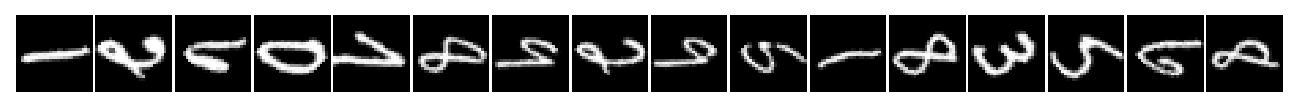

330

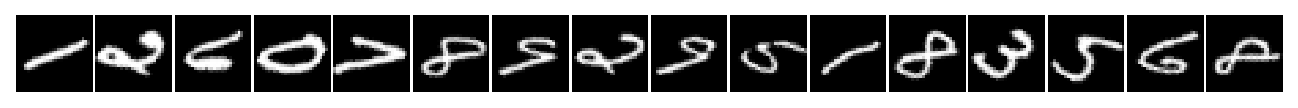

345

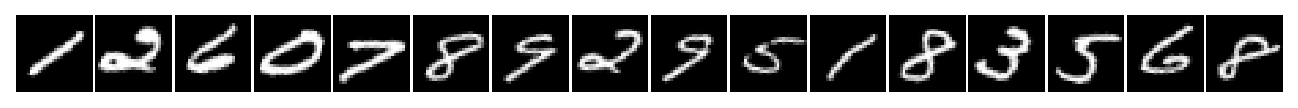

In [6]:
def do_it(tr, dl_name: str, delta_theta: float = 30, t: int = -1):
    dl = getattr(tr, f"dl_{dl_name}")
    thetas = range(0, 360 + 1, delta_theta)

    x_rot = collections.defaultdict(list)
    z_rot = collections.defaultdict(list)
    loss_recon = collections.defaultdict(list)
    
    for theta in tqdm(thetas):
        for x, *_ in iter(dl):
            _x = rotate(
                img=x,
                angle=theta,
                interpolation=InterpolationMode.BILINEAR,
            )
            output = tr.model.xtract_ftr(_x).stack()
            _z, _ = torch.chunk(tr.model.state, 2, 1)
    
            x_rot[theta].append(_x)
            z_rot[theta].append(_z)
            loss_recon[theta].append(output['loss_recon'])
    
    # fix recon
    loss_recon = {
        k: torch.cat(v).mean(0)[t].item()
        for k, v in loss_recon.items()
    }
    return x_rot, z_rot, loss_recon

In [7]:
x_rot_vld, z_rot_vld, loss_recon_vld = do_it(tr, 'vld')
x_rot_trn, z_rot_trn, loss_recon_trn = do_it(tr, 'trn')

100%|███████████████████████████████████████████| 13/13 [00:10<00:00,  1.28it/s]


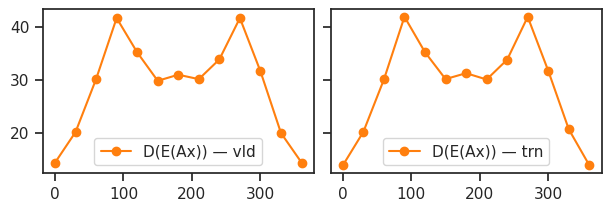

In [8]:
fig, axes = create_figure(1, 2, sharey='row')
axes[0].plot(loss_recon_vld.keys(), loss_recon_vld.values(), label='D(E(Ax)) — vld', color='C1', marker='o')
axes[1].plot(loss_recon_trn.keys(), loss_recon_trn.values(), label='D(E(Ax)) — trn', color='C1', marker='o')
add_legend(axes)
plt.show()

### rotate latent space

In [9]:
list(z_rot_trn)

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360]

In [10]:
src = [
    torch.cat(z) for theta, z
    in z_rot_trn.items()
    if theta != 360
]
tgt = src[1:] + [src[0]]

src = tonp(torch.cat(src))
tgt = tonp(torch.cat(tgt))

src.shape, tgt.shape

((720000, 128), (720000, 128))

In [21]:
mat = tgt.T @ src
u, _, vt = np.linalg.svd(mat)
rot_mat = u @ vt

rot_mat.shape

(128, 128)

In [22]:
# plt.plot(np.cumsum(s / sum(s))[:15], marker='o')

In [23]:
def is_rotation_matrix(a, tol=1e-6):
    is_orthonormal = np.allclose(a @ a.T, np.eye(a.shape[0]), atol=tol)
    determinant_is_one = np.isclose(np.linalg.det(a), 1.0, atol=tol)
    return is_orthonormal and determinant_is_one

In [24]:
print(is_rotation_matrix(rot_mat))

True

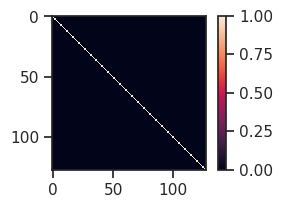

In [26]:
plt.imshow(rot_mat @ rot_mat.T)
plt.colorbar();

In [28]:
360 / 30

12.0

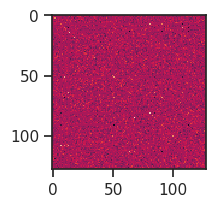

In [31]:
i = 12
a = np.linalg.matrix_power(rot_mat.T, i)

plt.imshow(a)

In [34]:
def rot_latent_mse(tr, rot_mat, dl_name: str = 'vld', delta_theta: float = 15):
    dl = getattr(tr, f"dl_{dl_name}")
    thetas = range(0, 360 + 1, delta_theta)
    loss_recon = collections.defaultdict(list)

    for i, theta in tqdm(enumerate(thetas), total=len(thetas)):
        # get rotation matrix
        a = np.linalg.matrix_power(rot_mat.T, i)
        a = tr.to(a)

        for x, *_ in iter(dl):
            # xtract latents
            output = tr.model.xtract_ftr(x).stack()
    
            # rotate latents
            z, _ = torch.chunk(tr.model.state, 2, 1)
            z_rot = z @ a
    
            # generate pred
            y_rot = tr.model.layer.decode(z_rot)
    
            # compute mse
            x_rot = rotate(
                img=x,
                angle=theta,
                interpolation=InterpolationMode.BILINEAR,
            ).flatten(start_dim=1)
            mse = tr.model.loss_recon(y_rot, x_rot)
            loss_recon[theta].append(mse)

    # fix recon
    loss_recon = {
        k: torch.cat(v).mean(0).item()
        for k, v in loss_recon.items()
    }
    return loss_recon

In [35]:
with torch.no_grad():
    loss_rot_recon_vld = rot_latent_mse(tr, rot_mat, 'vld')
    loss_rot_recon_trn = rot_latent_mse(tr, rot_mat, 'trn')

100%|███████████████████████████████████████████| 25/25 [00:20<00:00,  1.20it/s]


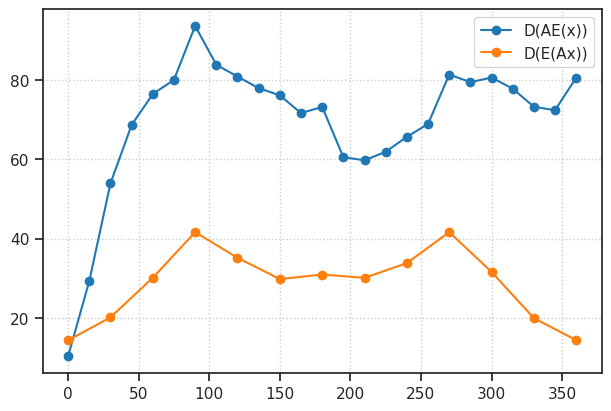

In [40]:
fig, ax = create_figure(1, 1, (6, 4))
ax.plot(loss_rot_recon_vld.keys(), loss_rot_recon_vld.values(), label='D(AE(x))', color='C0', marker='o')
ax.plot(loss_recon_vld.keys(), loss_recon_vld.values(), label='D(E(Ax))', color='C1', marker='o')
add_legend(ax)
add_grid(ax)
plt.show()

original:

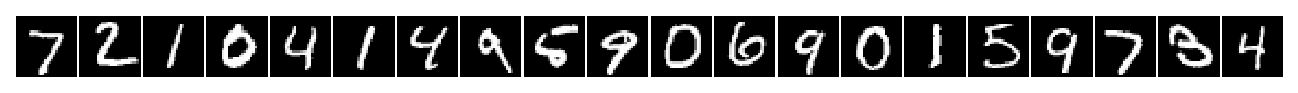

______________________________________________________________________________________________________________

0

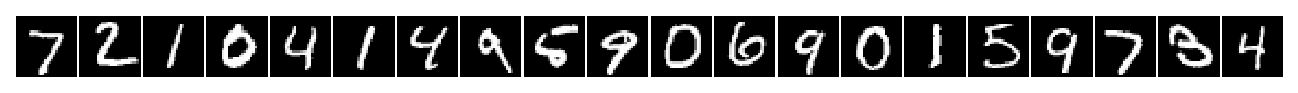

30

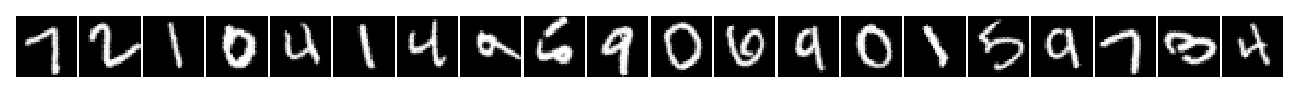

60

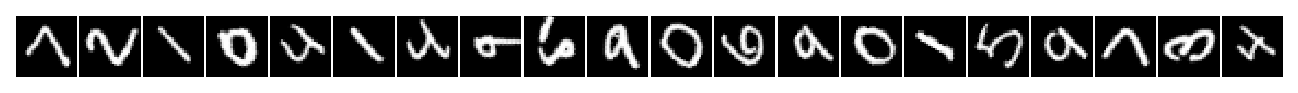

90

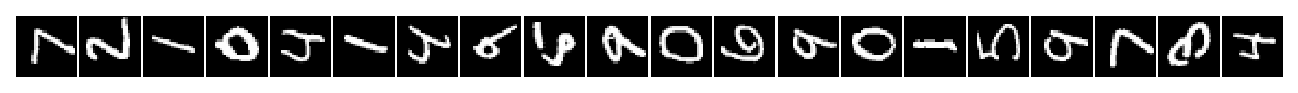

120

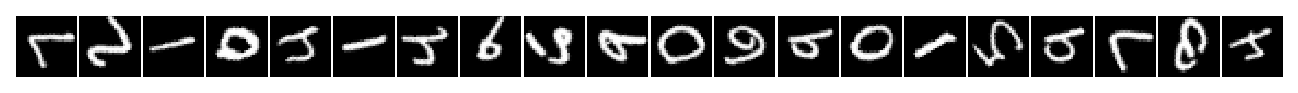

150

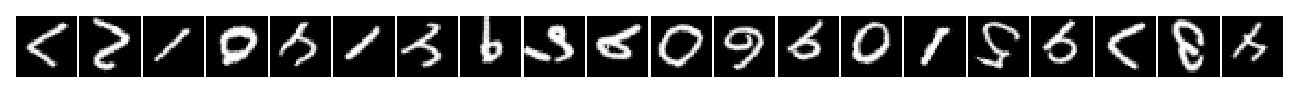

180

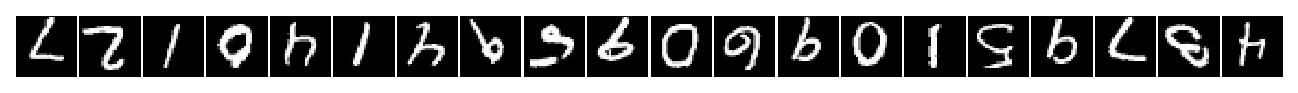

210

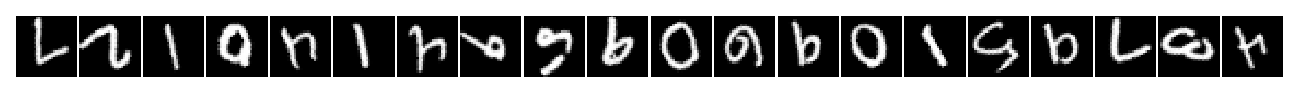

240

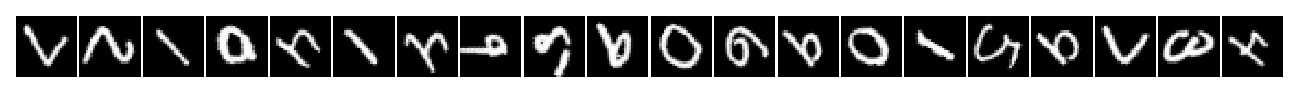

270

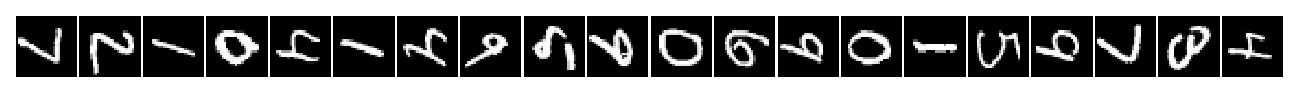

300

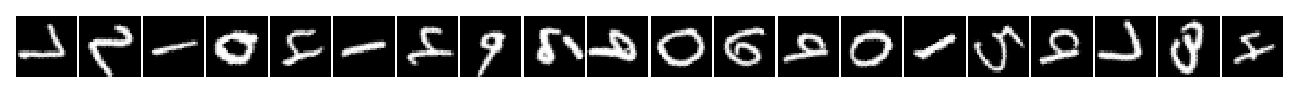

330

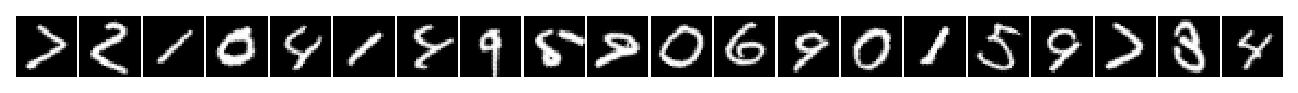

360

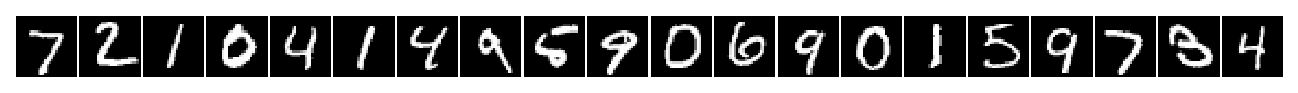

In [41]:
x = next(iter(tr.dl_vld))[0]
print('original:')
_ = plot_weights(tonp(x[:20, 0]), nrows=1)
print('_' * 110)

for theta, x_rot in x_rot_vld.items():
    print(theta)
    _ = plot_weights(tonp(x_rot[0][:20, 0]), nrows=1)

## Now do Poisson

In [4]:
models2load = {
    'iterative': dict(
        model_name='poisson_MNIST_t-32_z-[128]_<jacob|mlp>',
        fit_name='u:(8.0)-du:(7.0)_b200-ep500-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,10:55)',
        device=device,
        shuffle=False,
    ),
    'amortized': dict(
        model_name='poisson_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep500-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,17:45)',
        device=device,
        shuffle=False,
    )
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}

### make plot

iterative

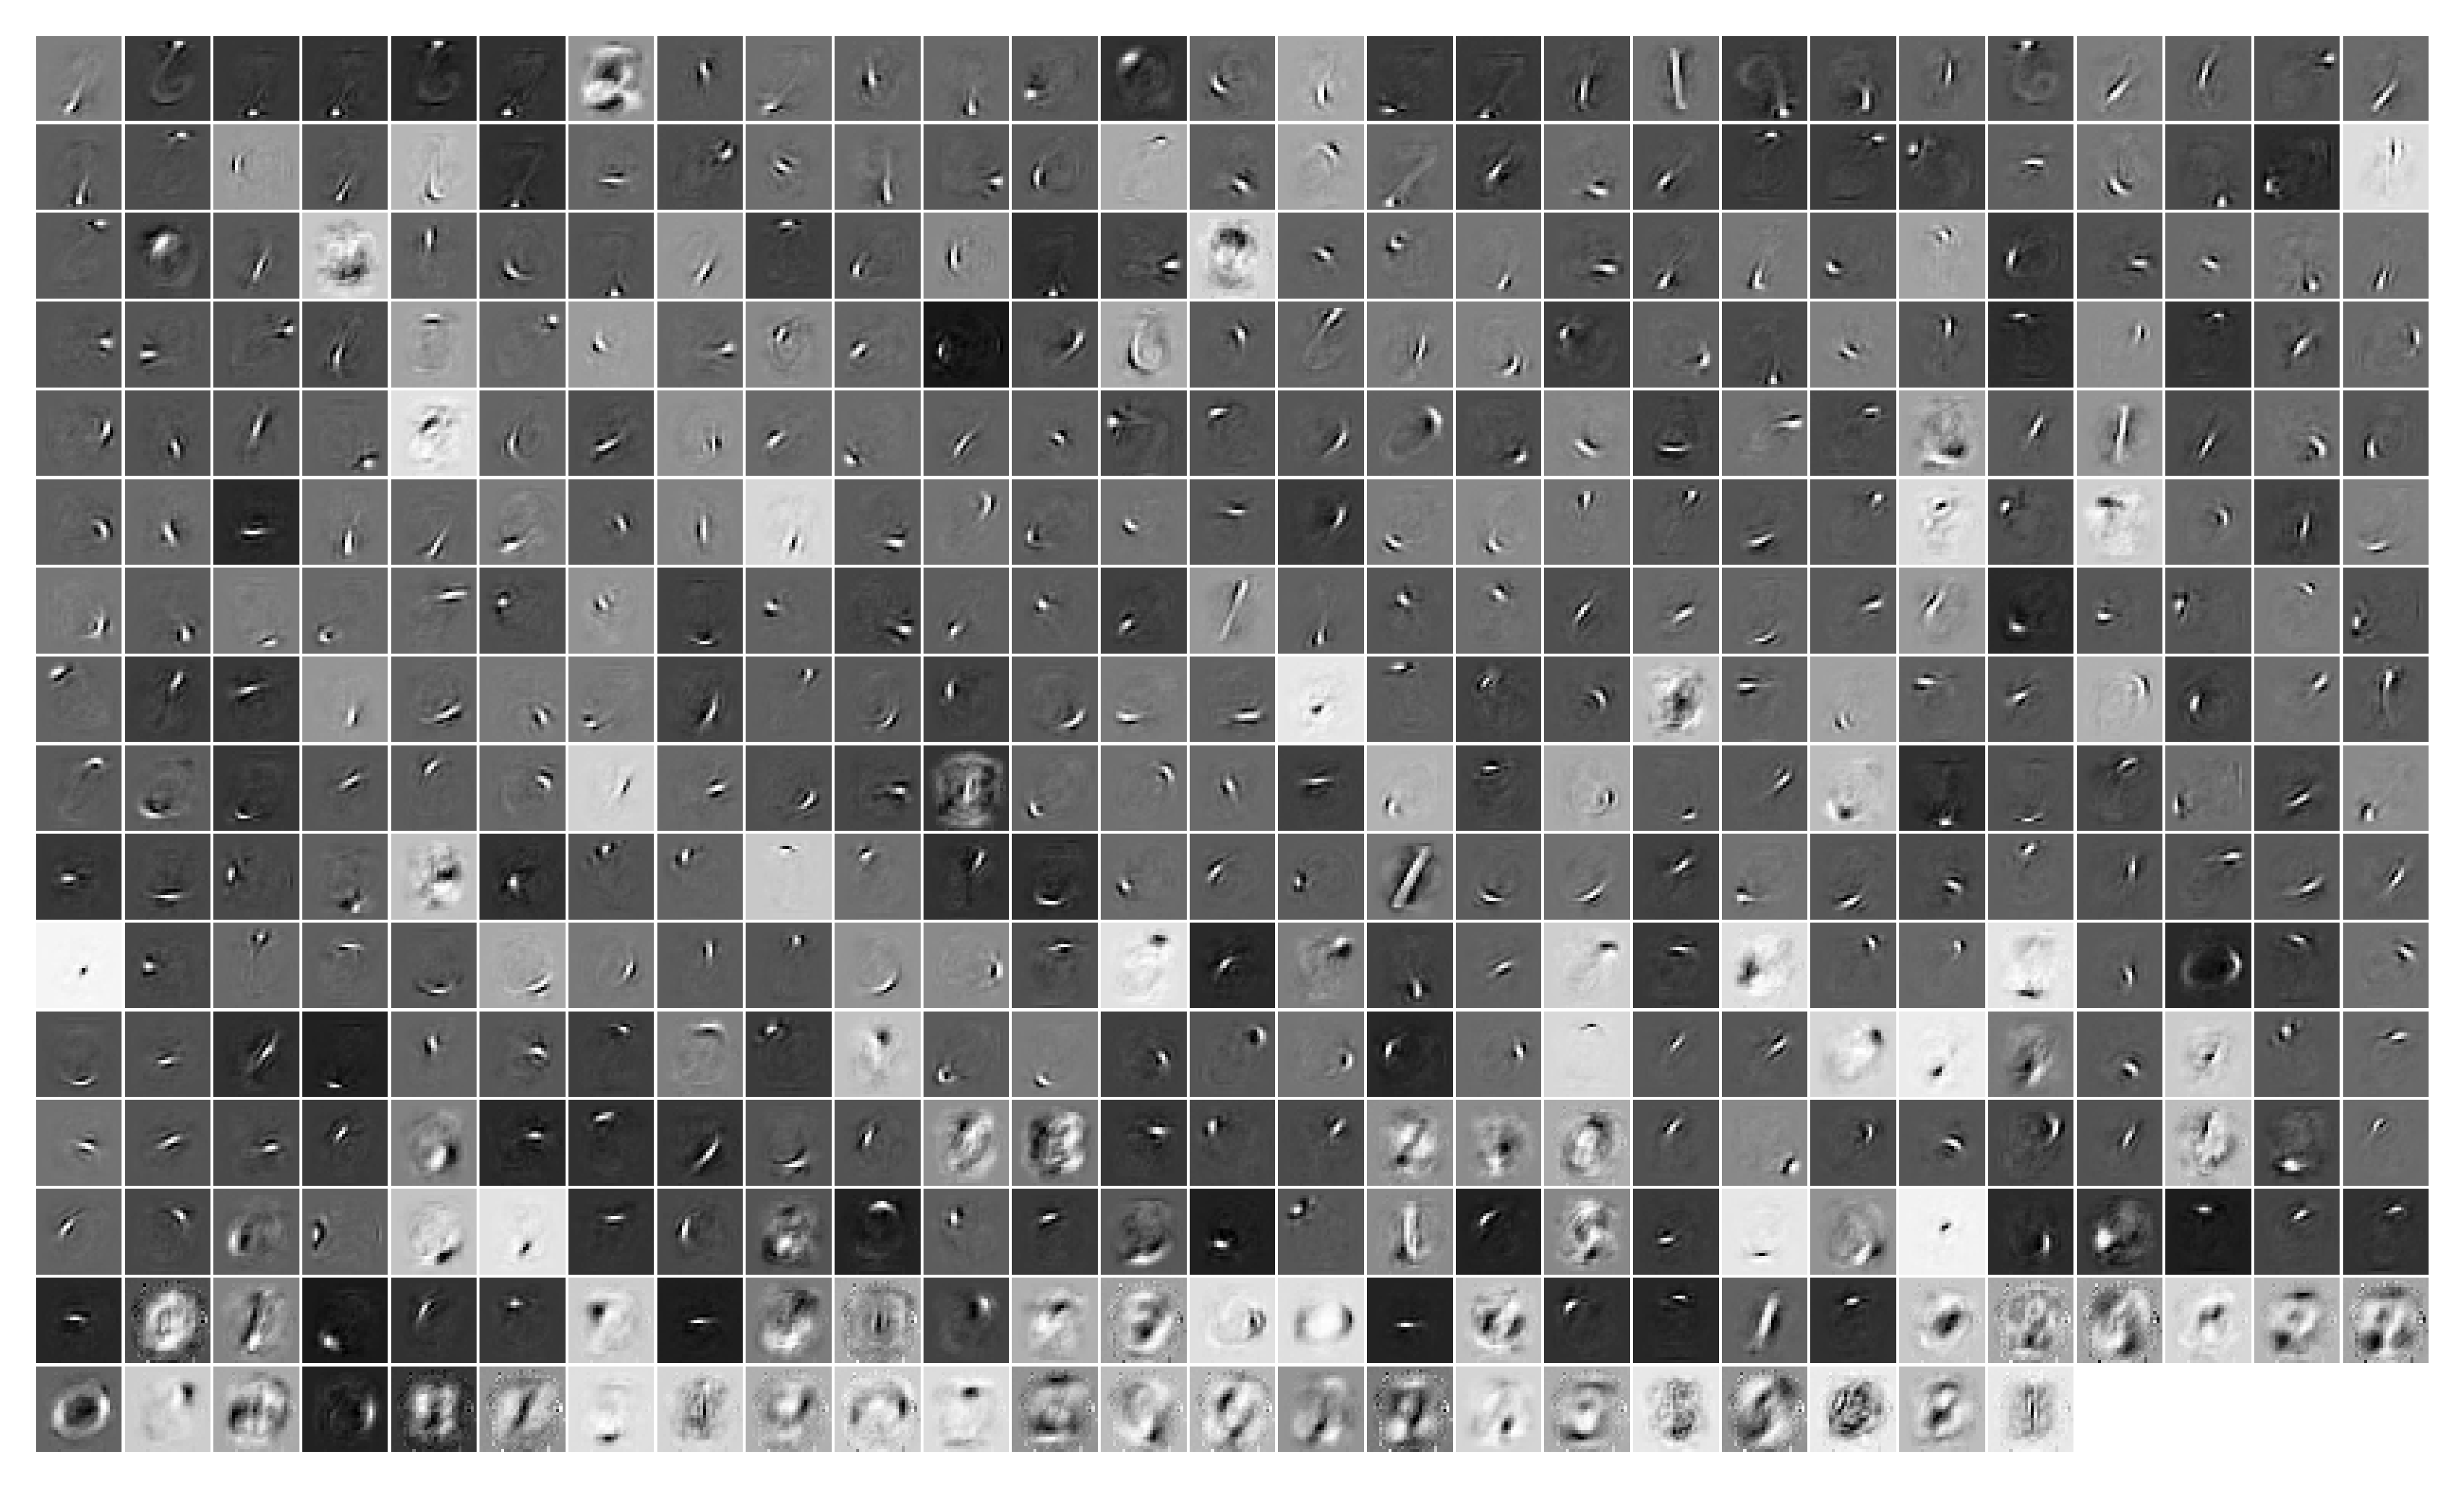

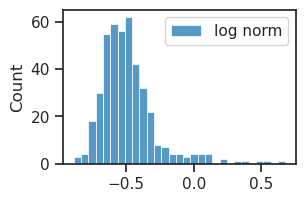

______________________________________________________________________________________________________________

______________________________________________________________________________________________________________

amortized

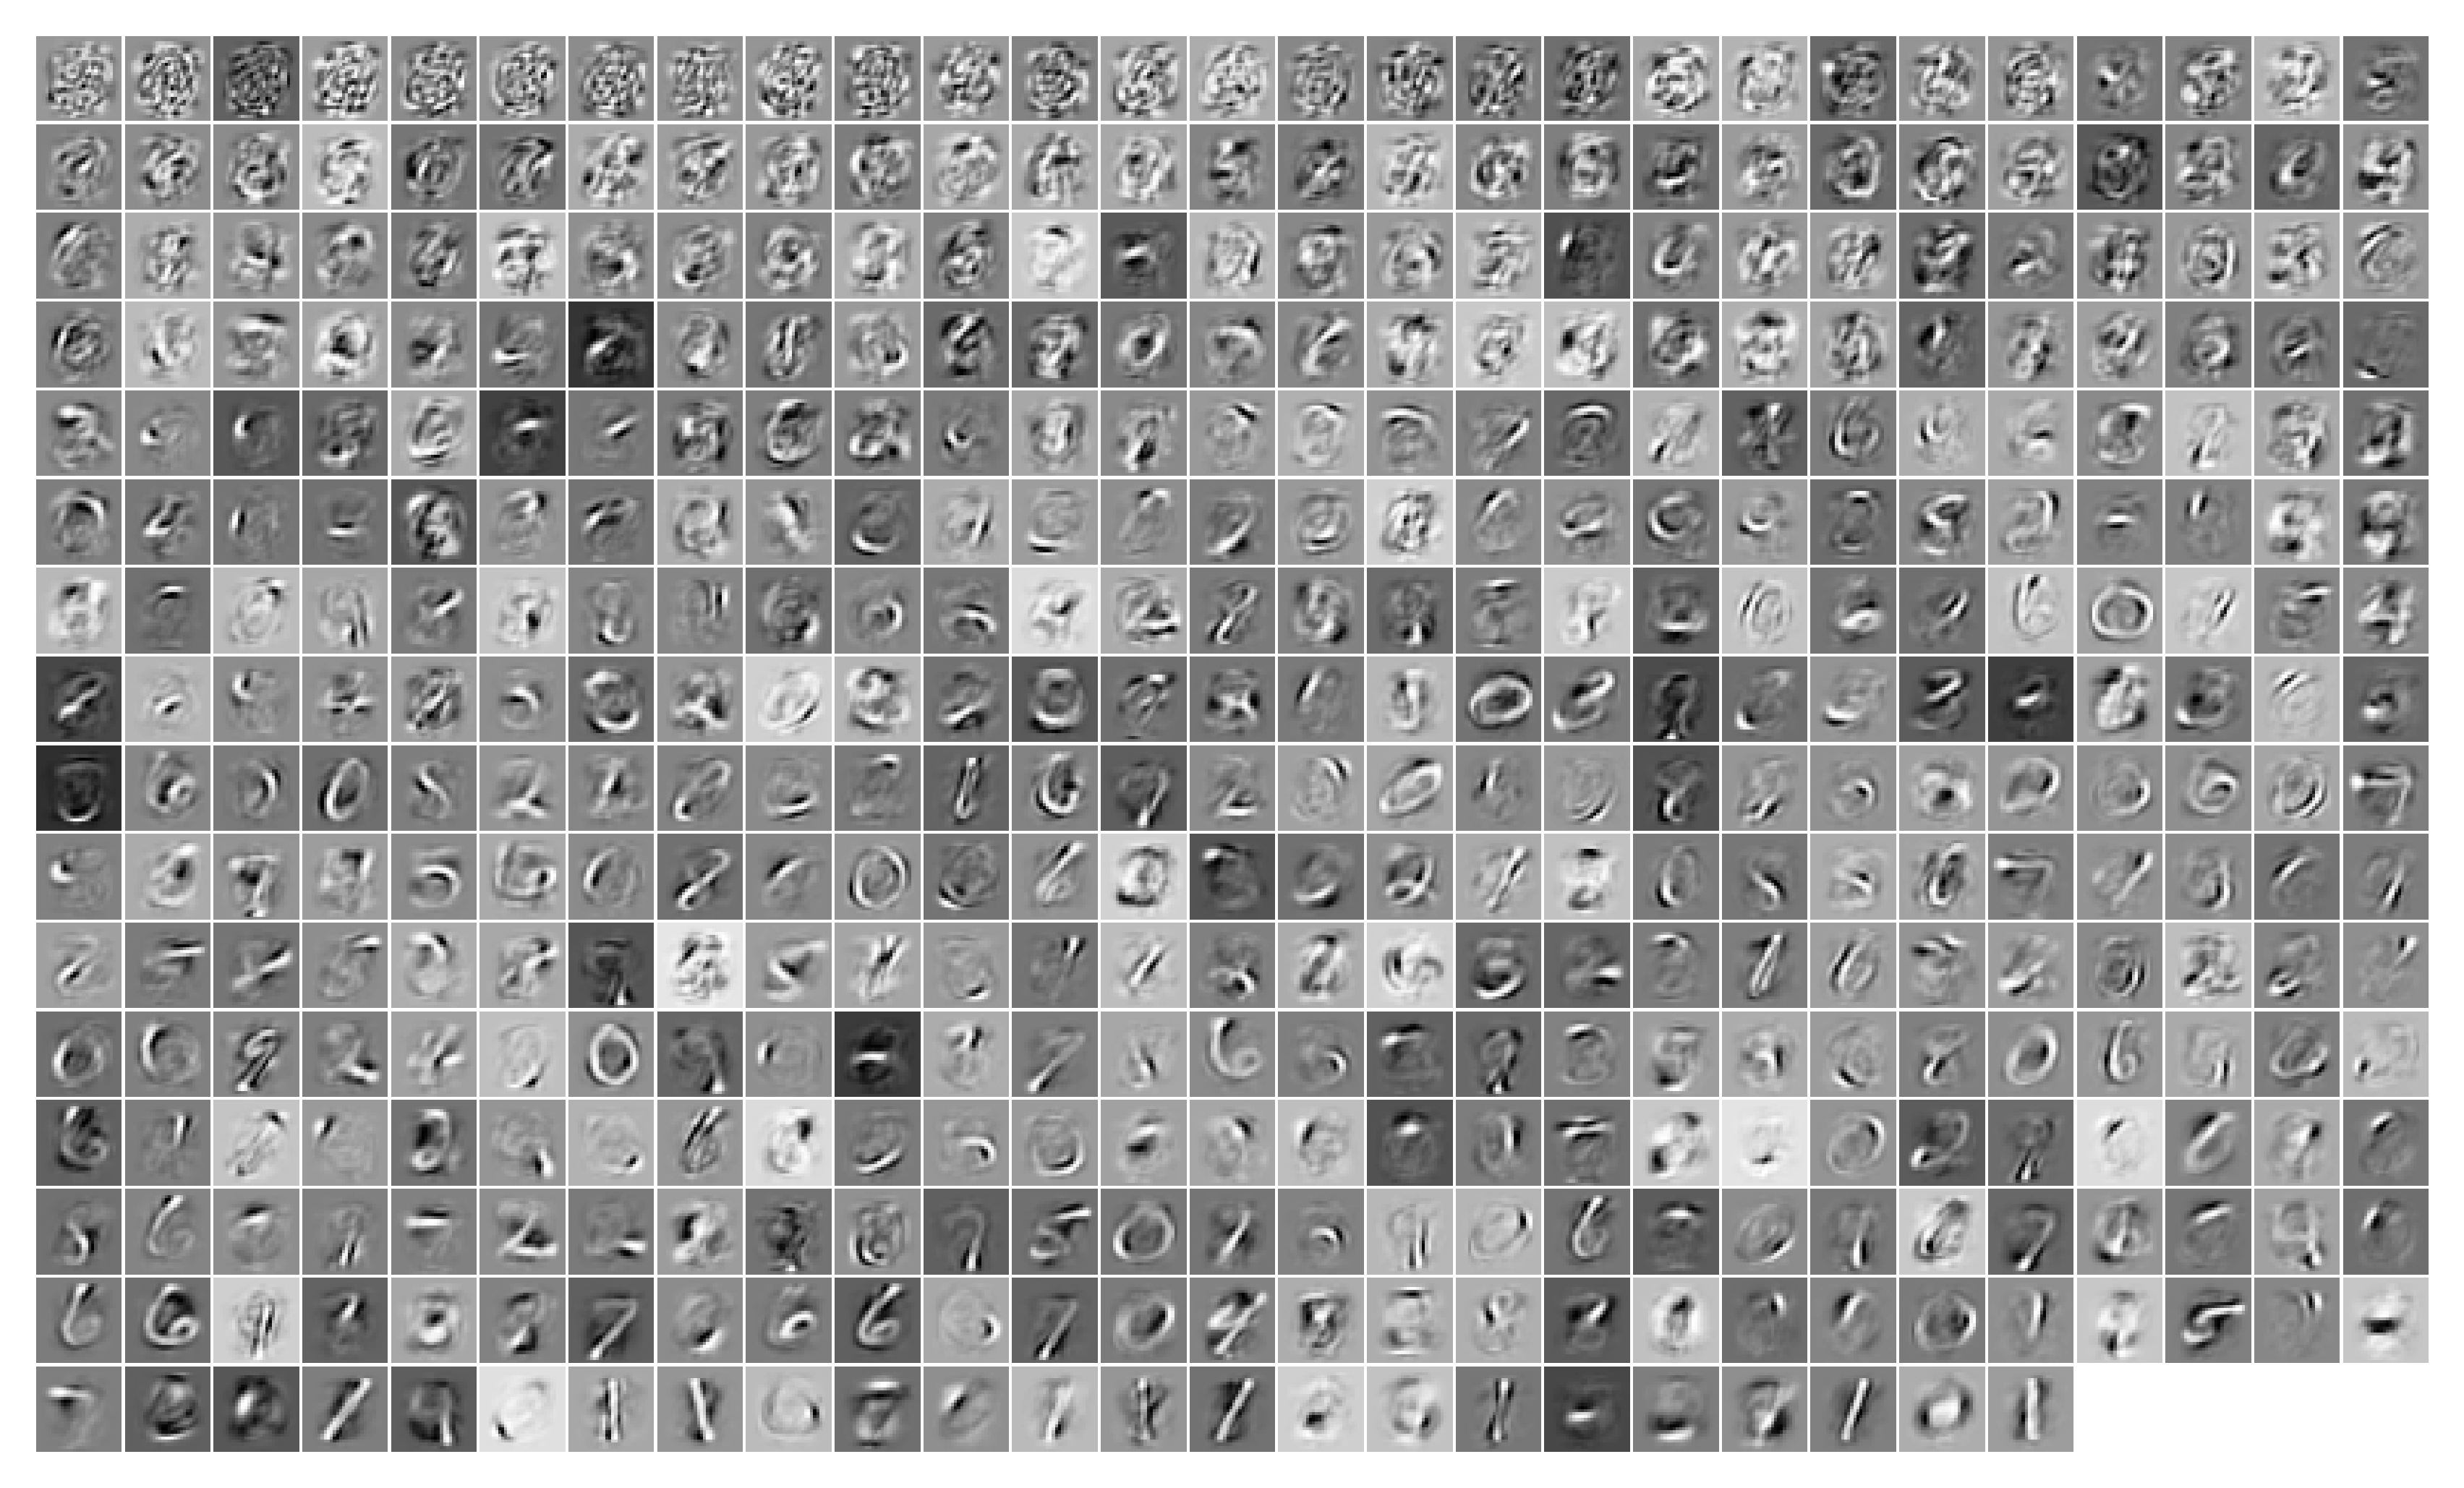

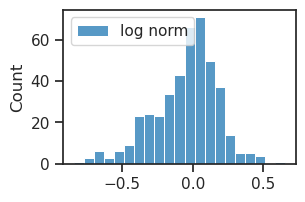

______________________________________________________________________________________________________________

______________________________________________________________________________________________________________

In [6]:
for name, tr in trainers.items():
    print(name)
    
    w = tr.model.layer.get_weight()
    norms = tonp(torch.linalg.vector_norm(w, dim=1))
    
    fig, ax = tr.model.show(order=np.argsort(norms), dpi=500)
    fig.savefig(pjoin(fig_base_dir, f'mlp-MNIST-poisson-{name}.pdf'), bbox_inches='tight')

    sns.histplot(np.log(norms), label='log norm')
    plt.legend()
    plt.show()

    print('_' * 110)
    print('_' * 110)
    print('\n\n')

In [7]:
delta_theta = 10
kws = dict(tr=trainers['iterative'], delta_theta=delta_theta, t=-1, verbose=True)
dl_rot_trn, mse_pixel_trn = make_rotation_dataloaders(
    dl_name='trn', full_data=False, **kws)

100%|█████████████████████████████████████████| 300/300 [10:15<00:00,  2.05s/it]


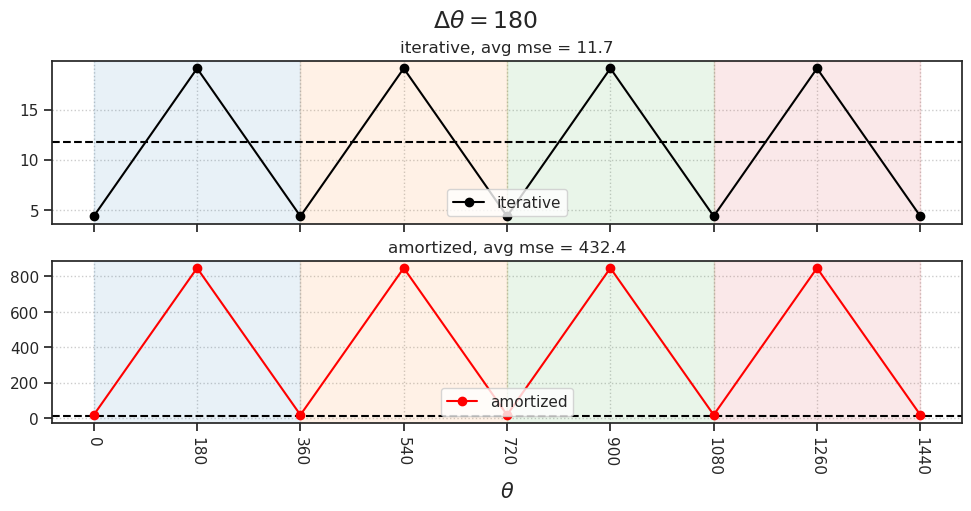

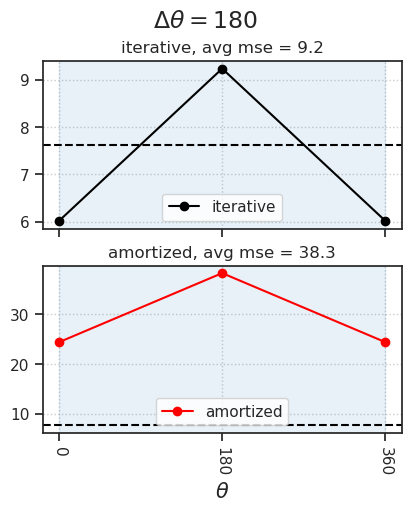

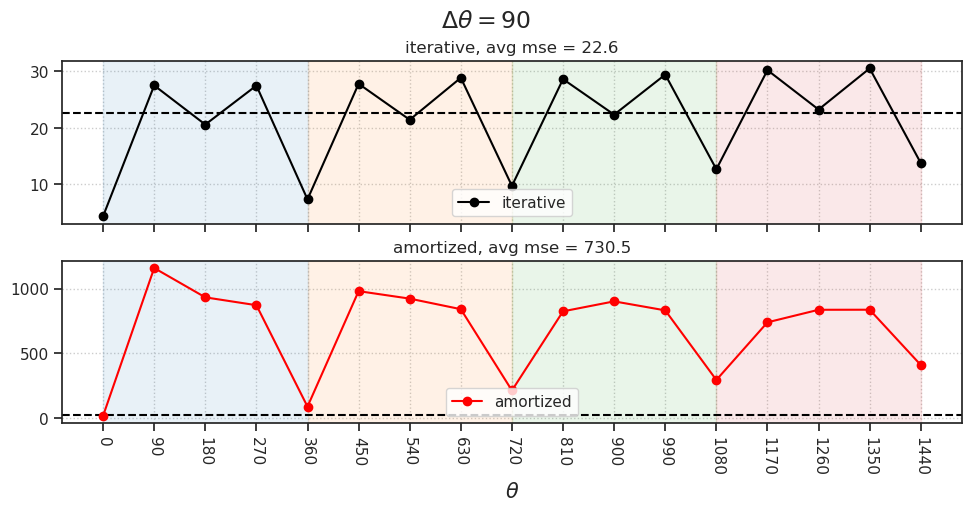

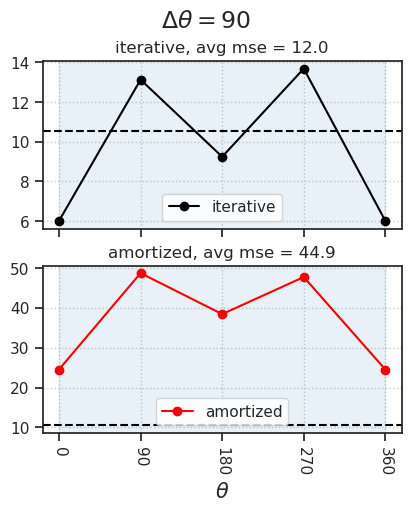

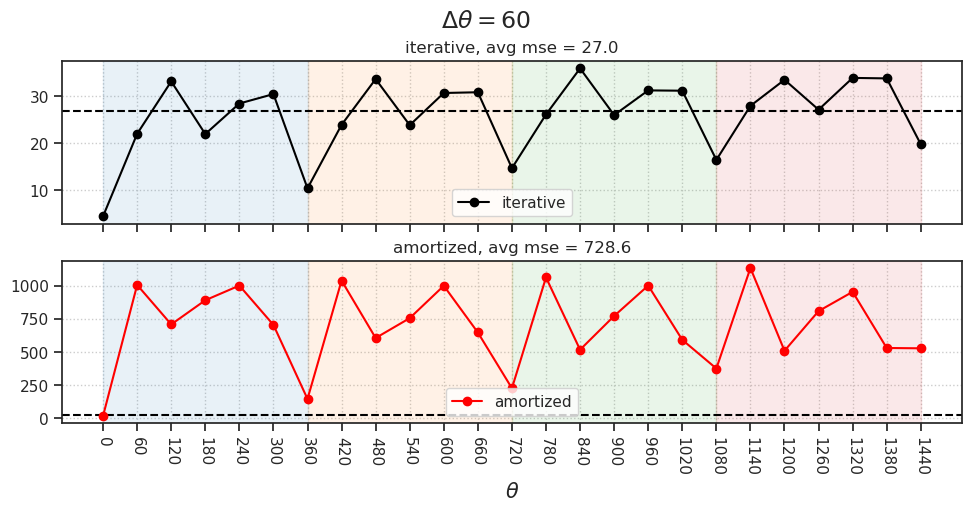

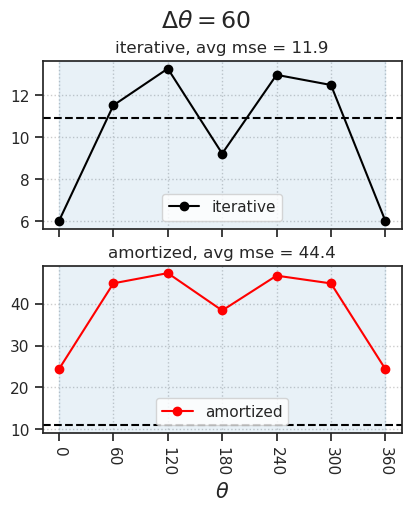

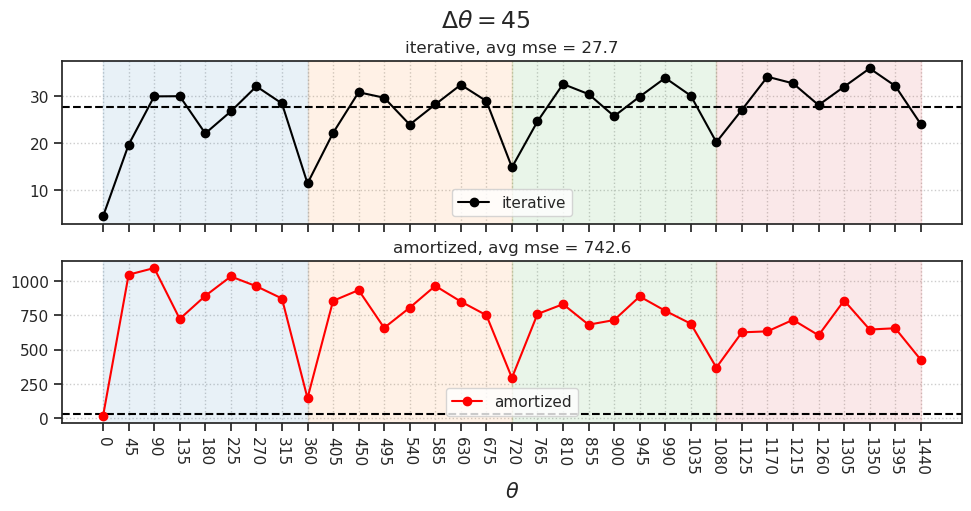

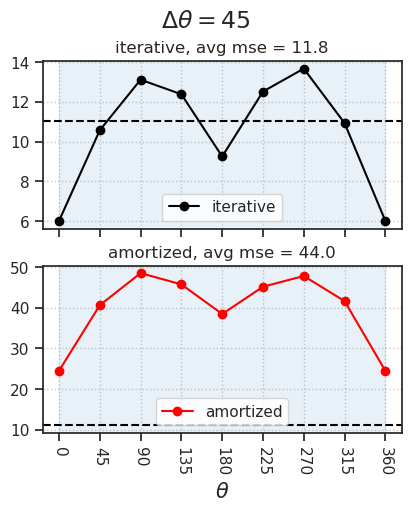

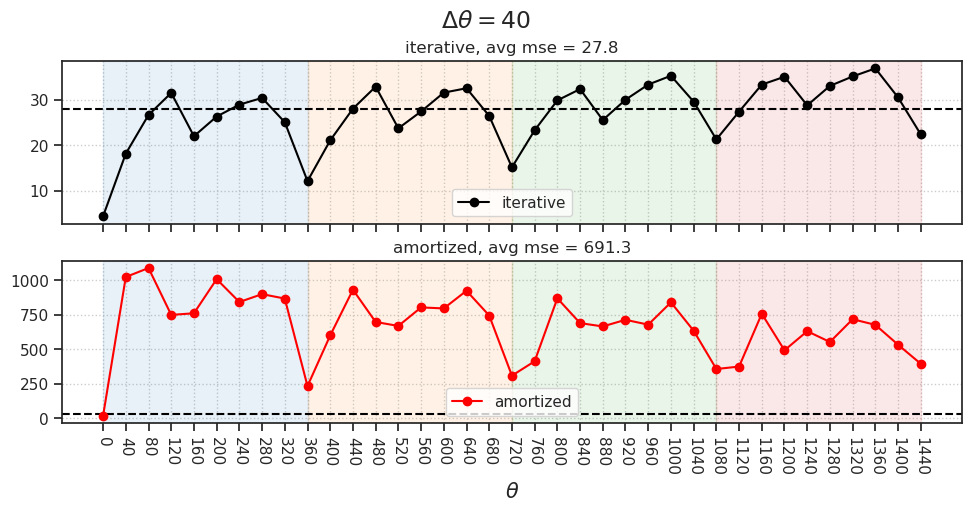

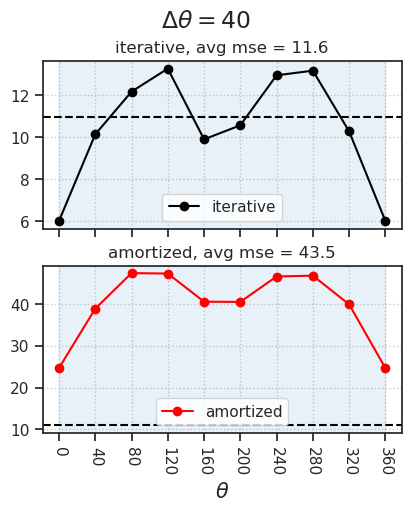

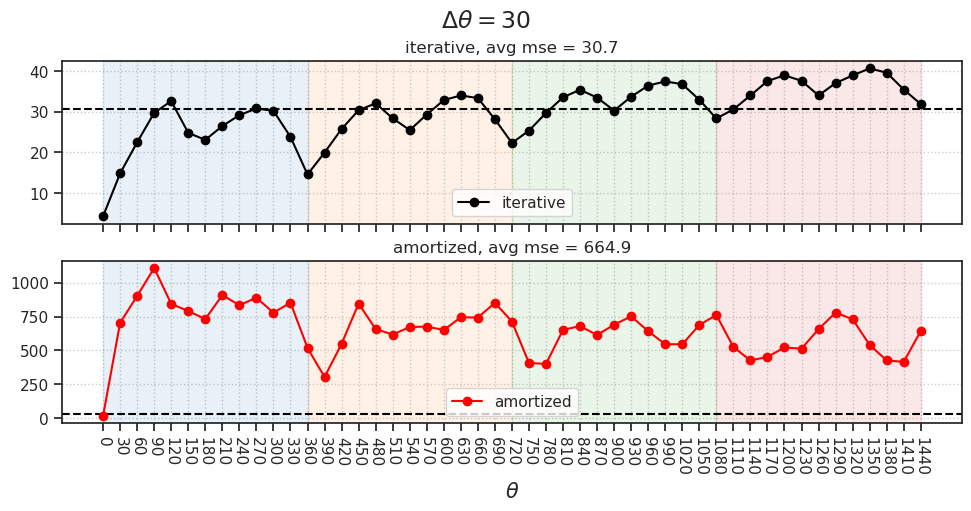

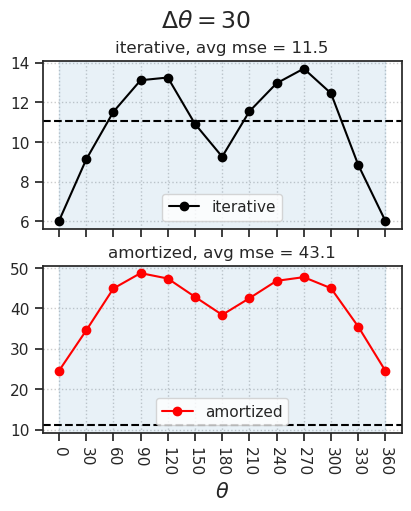

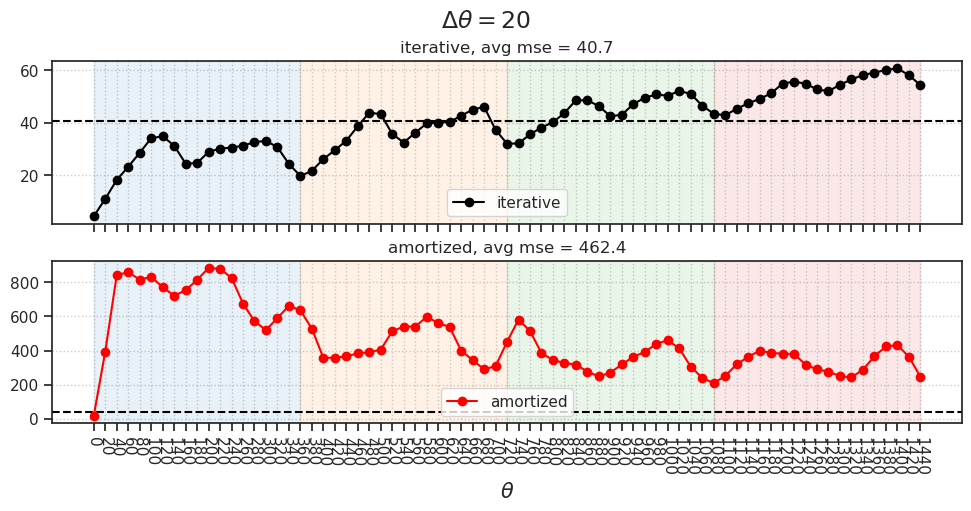

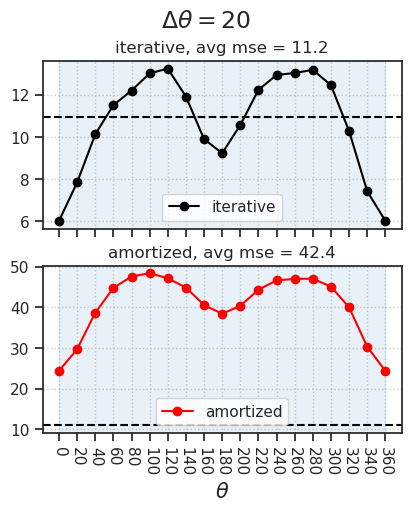

CPU times: user 20min 48s, sys: 12.2 s, total: 21min
Wall time: 18min 2s


In [6]:
%%time

kws = dict(num_rounds=4, use_rates=True, t=-1)

rotation_results_all = {}
for delta_theta in [180, 90, 60, 45, 40, 30, 20]:
    kws['delta_theta'] = delta_theta
    rotation_results = {
        name: preform_rotation_analysis(tr, **kws)
        for name, tr in trainers.items()
    }
    rotation_results_all[delta_theta] = rotation_results

    _plot(rotation_results, 'mse_latent')
    _plot(rotation_results, 'mse_pixel_vld')

In [17]:
kws = dict(spacing=0.001, num_rounds=1, n_data_batches=1)

results_iter, angles = slow_rotate_batch(trainers['iterative'], reset=False, **kws)
results_amort, angles = slow_rotate_batch(trainers['amortized'], reset=True, **kws)

100%|█████████████████████████████████| 360000/360000 [1:01:59<00:00, 96.80it/s]


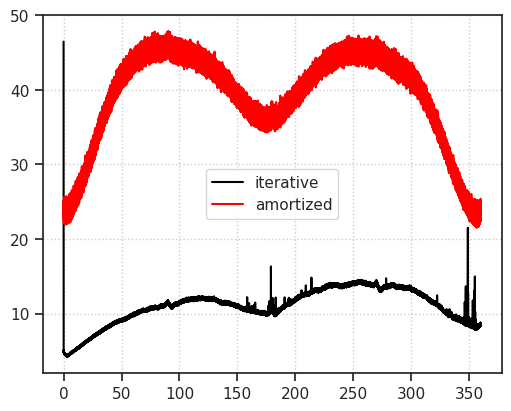

In [22]:
fig, ax = create_figure(1, 1, (5, 4))
ax.plot(angles, tonp(results_iter['mse'].mean(0)), label='iterative', color='k')
ax.plot(angles, tonp(results_amort['mse'].mean(0)), label='amortized', color='r')
add_legend(ax)
add_grid(ax)
plt.show()

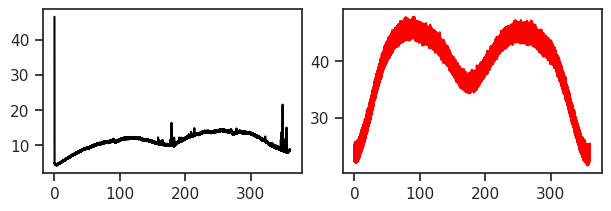

In [19]:
fig, axes = create_figure(1, 2)
axes[0].plot(angles, tonp(results_iter['mse'].mean(0)), color='k')
axes[1].plot(angles, tonp(results_amort['mse'].mean(0)), color='r')
plt.show()

In [7]:
dl_rot_vld, recon_pixel_vld = make_rotation_dataloaders(tr, 'vld', delta_theta=delta_theta)
dl_rot_trn, recon_pixel_trn = make_rotation_dataloaders(tr, 'trn', delta_theta=delta_theta)

100%|█████████████████████████████████████████| 300/300 [02:03<00:00,  2.43it/s]


In [8]:
print({
    k: v.mean(0)[-1].item() for
    k, v in recon_pixel_vld.items()
})

{
    0: 6.01228666305542,
    40: 10.12661075592041,
    80: 12.194077491760254,
    120: 13.264482498168945,
    160: 9.894977569580078,
    200: 10.575679779052734,
    240: 12.954391479492188,
    280: 13.18549633026123,
    320: 10.290305137634277
}

In [9]:
## Was (T, beta) = (10, 5.0)

{
    0: 9.482181549072266,
    40: 15.895050048828125,
    80: 19.879552841186523,
    120: 20.550315856933594,
    160: 16.123004913330078,
    200: 16.629894256591797,
    240: 20.19991111755371,
    280: 20.464702606201172,
    320: 16.05736541748047,
    360: 9.468527793884277
}

In [9]:
print({
    theta: [x.shape for x in dl.dataset.tensors]
    for theta, dl in dl_rot_trn.items()
})

{
    0: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    40: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    80: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    120: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    160: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    200: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    240: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    280: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])],
    320: [torch.Size([60000, 1, 28, 28]), torch.Size([60000]), torch.Size([60000, 32, 128])]
}

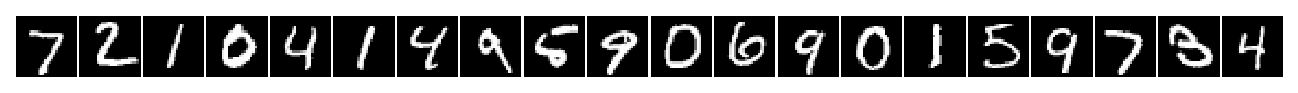

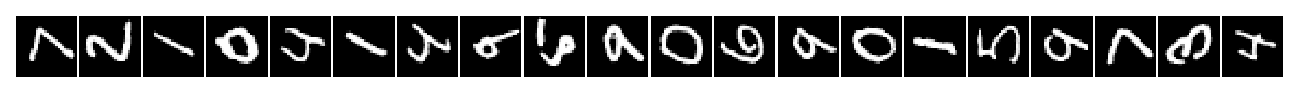

In [12]:
num = 20

theta = 0
x2p = tonp(next(iter(dl_rot_vld[theta]))[0].squeeze())
_ = plot_weights(x2p[:num], nrows=1)

theta = 80
x2p = tonp(next(iter(dl_rot_vld[theta]))[0].squeeze())
_ = plot_weights(x2p[:num], nrows=1)

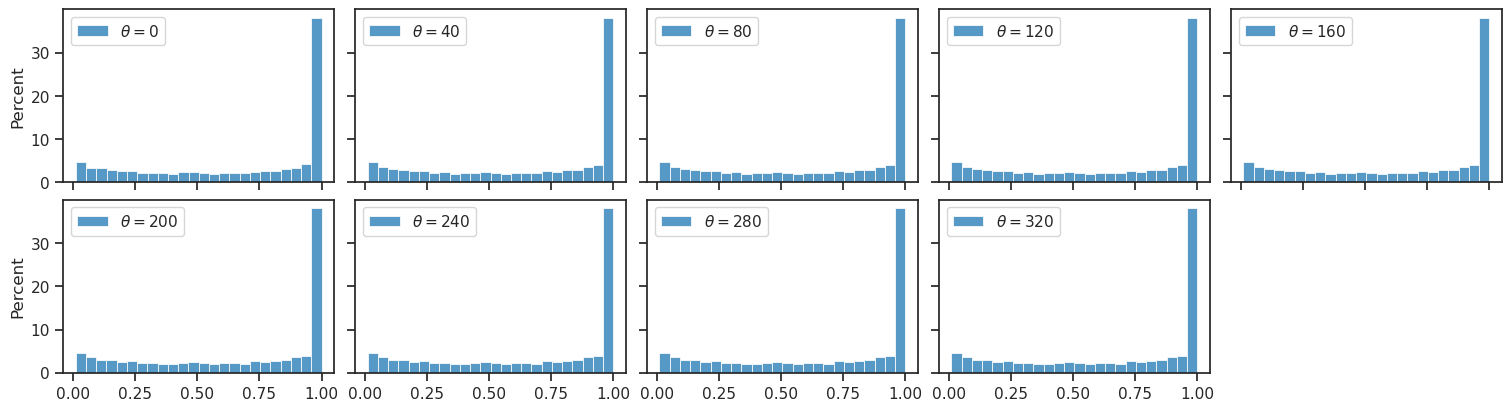

In [15]:
nrows = 2
ncols = int(np.ceil(len(dl_rot_vld) / nrows))
fig, axes = create_figure(nrows, ncols, sharex='all', sharey='all')

for i, (theta, dl) in enumerate(dl_rot_vld.items()):
    ax = axes.flat[i]
    x2p = next(iter(dl))[0]
    x2p = tonp(x2p.ravel())
    x2p = x2p[x2p > 0.01]
    sns.histplot(x2p, label=r"$\theta = $" + f"{theta}", stat='percent', ax=ax)
axes = trim_axs(axes, len(dl_rot_vld))
add_legend(axes)
plt.show()

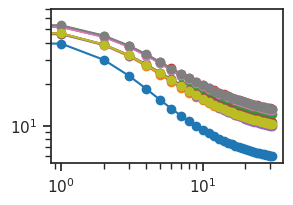

In [16]:
for i, (theta, mse) in enumerate(recon_pixel_vld.items()):
    plt.loglog(tonp(mse.mean(0)), color=f'C{i}', marker='o')
plt.show()

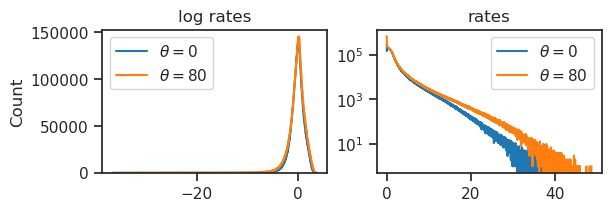

In [17]:
fig, axes = create_figure(1, 2)

kws = dict(element='step', fill=False)

theta = 0
u2p = tonp(dl_rot_vld[theta].dataset.tensors[-1].ravel())
sns.histplot(u2p, label=r'$\theta = $'+ f'{theta}', ax=axes[0], **kws)
sns.histplot(np.exp(u2p), label=r'$\theta = $'+ f'{theta}', ax=axes[1], **kws)

theta = 80
u2p = tonp(dl_rot_vld[theta].dataset.tensors[-1].ravel())
sns.histplot(u2p, label=r'$\theta = $'+ f'{theta}', ax=axes[0], **kws)
sns.histplot(np.exp(u2p), label=r'$\theta = $'+ f'{theta}', ax=axes[1], **kws)

axes[0].set(yscale='linear', title='log rates')
axes[1].set(yscale='log', title='rates', ylabel='')
add_legend(axes)

plt.show()

### rotate latent space

In [19]:
rot_mat, src_mean, tgt_mean = learn_rotation_matrix(dl_rot_vld, exp=True)

In [20]:
_ = is_rotation_matrix(rot_mat, verbose=True)
rot_mat.shape, np.linalg.det(rot_mat)

is orthonormal : True,  determinant = +1 : True

((128, 128), 1.0000002)

In [ ]:
			# u_true = data[i % ratio][-1]
			# u_true = u_true[:, t, :]
			# z_true = torch.exp(u_true)
			# y_rot_true = tr.model.layer.decode(z_true)

	#     if i == 2:
	#         break
	# break


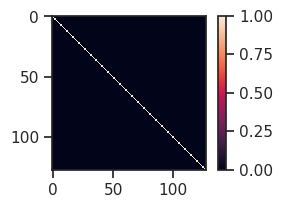

In [12]:
plt.imshow(rot_mat @ rot_mat.T)
plt.colorbar();

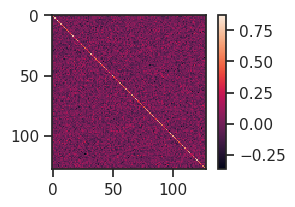

In [13]:
i = int(360 / delta_theta)
a = torch.linalg.matrix_power(
    tr.to(rot_mat).T, i)

plt.imshow(tonp(a))
plt.colorbar()

In [14]:
dl_rot_vld

{0: <torch.utils.data.dataloader.DataLoader at 0x7f0852a95350>,
 40: <torch.utils.data.dataloader.DataLoader at 0x7f0850cb2550>,
 80: <torch.utils.data.dataloader.DataLoader at 0x7f08535c9ed0>,
 120: <torch.utils.data.dataloader.DataLoader at 0x7f0850ccfc10>,
 160: <torch.utils.data.dataloader.DataLoader at 0x7f08523a7c10>,
 200: <torch.utils.data.dataloader.DataLoader at 0x7f07b6d87f50>,
 240: <torch.utils.data.dataloader.DataLoader at 0x7f07b6d87450>,
 280: <torch.utils.data.dataloader.DataLoader at 0x7f07b6dc6e90>,
 320: <torch.utils.data.dataloader.DataLoader at 0x7f07b6dc4ed0>}

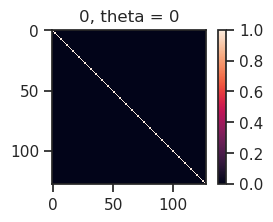

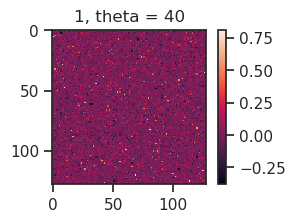

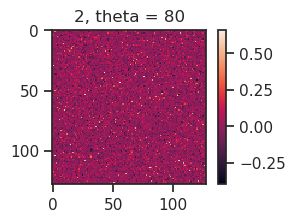

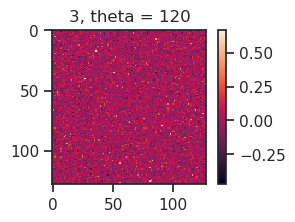

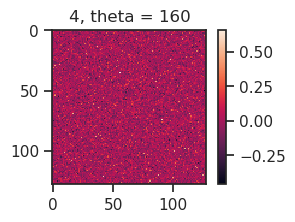

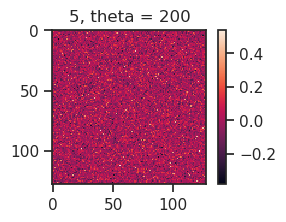

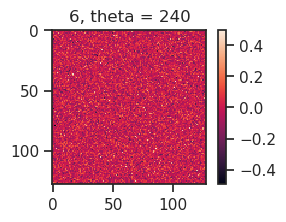

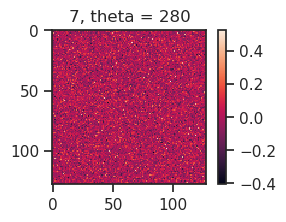

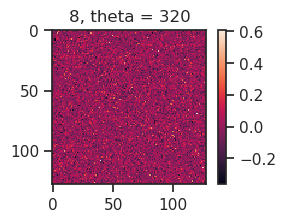

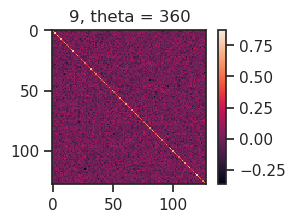

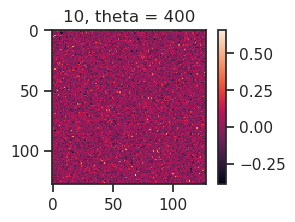

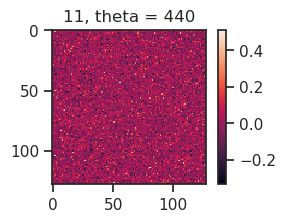

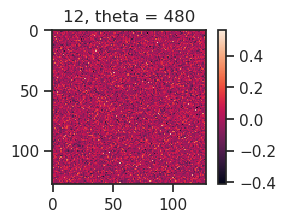

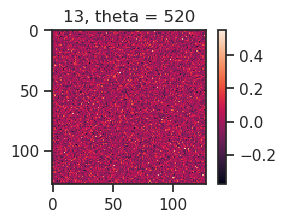

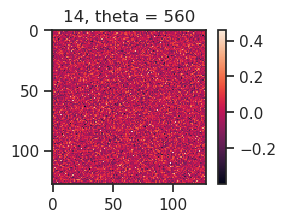

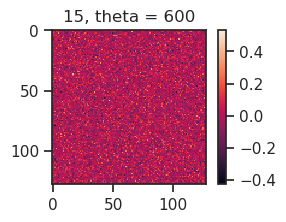

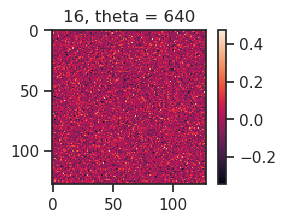

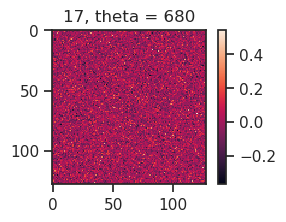

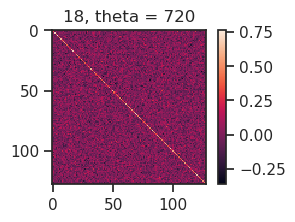

In [15]:
rot_mat = tr.to(rot_mat)
num_rounds = 2

for i in range(num_rounds * int(360 / delta_theta) + 1):
    a = torch.linalg.matrix_power(
        rot_mat.T, i)
    theta = i * delta_theta
    plt.imshow(tonp(a))
    plt.title(f"{i}, theta = {theta}")
    plt.colorbar()
    plt.show()

In [ ]:
# dl_other = [
#     dl for theta, dl in
#     dl_rot_vld.items()
#     if theta > 0
# ]

In [23]:
loss_recon_latent

{0: 4.364027976989746,
 40: 18.16623306274414,
 80: 26.734792709350586,
 120: 31.32450294494629,
 160: 21.92494010925293,
 200: 26.63072395324707,
 240: 29.081533432006836,
 280: 30.073333740234375,
 320: 25.177932739257812,
 360: 12.19692325592041,
 400: 21.087535858154297,
 440: 28.01966094970703,
 480: 33.40013122558594,
 520: 24.288009643554688,
 560: 27.774324417114258,
 600: 31.76383399963379,
 640: 33.2110481262207,
 680: 26.534120559692383,
 720: 15.287148475646973}

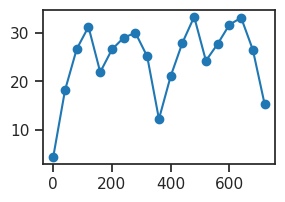

In [25]:
plt.plot(loss_recon_latent.keys(), loss_recon_latent.values(), marker='o')

In [16]:
loss_recon

{0: 6.008642673492432,
 90: 32.10231018066406,
 180: 24.296701431274414,
 270: 33.443965911865234,
 360: 9.749547004699707,
 450: 32.74656295776367,
 540: 24.87472152709961,
 630: 33.88258743286133,
 720: 12.92251968383789}

{0: 4.364739894866943,
 90: 27.498268127441406,
 180: 20.907047271728516,
 270: 27.501474380493164,
 360: 7.63425350189209,
 450: 27.62897491455078,
 540: 21.564489364624023,
 630: 28.48583984375,
 720: 10.013694763183594}

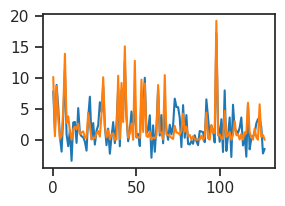

In [21]:
plt.plot(tonp(z_rot[0]))
plt.plot(tonp(z_true[0]))

In [23]:
u_rot - u_true

tensor([[-0.1907, -1.2829, -0.9184,  ..., -0.8574,  0.2194,  1.5112],
        [-0.0234, -0.2706, -0.1086,  ...,  1.6865,  0.1931,  0.1892],
        [-1.3136, -0.3811, -0.3347,  ..., -1.6591,  0.5054, -0.8589],
        ...,
        [ 0.7917,  0.2723,  1.4304,  ..., -0.9207,  1.0898, -0.4446],
        [-1.0291, -0.9635, -0.6696,  ...,  0.4814,  0.1860, -0.4889],
        [ 0.3646, -1.7867,  0.5609,  ..., -0.5407,  0.2036,  0.4175]],
       device='cuda:1')

In [19]:
u_rot.shape

torch.Size([200, 128])

In [20]:
u_true.shape

torch.Size([200, 32, 128])

In [59]:
src_mean.shape

torch.Size([1, 128])

In [60]:
tgt_mean.shape

torch.Size([1, 128])

In [54]:
loss_recon

{0: 4.365821838378906,
 40: 7.98746919631958,
 80: 9.686543464660645,
 120: 10.791757583618164,
 160: 7.700267791748047,
 200: 8.373418807983398,
 240: 10.482625961303711,
 280: 10.706992149353027,
 320: 8.119890213012695,
 360: 4.365821838378906,
 400: 7.98746919631958,
 440: 9.686543464660645,
 480: 10.791757583618164,
 520: 7.700267791748047,
 560: 8.373418807983398,
 600: 10.482625961303711,
 640: 10.706992149353027,
 680: 8.119890213012695,
 720: 4.365821838378906}

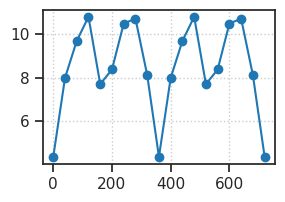

In [58]:
plt.plot(loss_recon.keys(), loss_recon.values(), marker='o')
plt.grid()

In [ ]:
dl0 = dl_rot_vld[0]




    for x, _, u in iter(dl0):

        # compute mse
        theta = i * delta_theta
        x_rot = dl_rot_vld[theta].flatten(start_dim=1)
        mse = tr.model.loss_recon(y_rot, x_rot)
        loss_recon[theta].append(mse)

In [55]:
@torch.no_grad()
def rot_latent_mse(tr, dl_name: str, delta_theta: float, t: int = None):
    dl = getattr(tr, f"dl_{dl_name}")
    seq = range(t or tr.model.cfg.seq_len)
    thetas = range(0, 360 + 1, delta_theta)
    loss_recon = collections.defaultdict(list)

    for i, theta in tqdm(enumerate(thetas), total=len(thetas)):
        # get rotation matrix
        a = torch.linalg.matrix_power(
            rot_mat.T, i)

        for x, *_ in iter(dl):
            # xtract latents
            output = tr.model.xtract_ftr(x, seq=seq)
            output = output.stack()

            # rotate latents
            z = torch.exp(tr.model.state)
            z_rot = (z - src_mean) @ a + tgt_mean

            # generate pred  
            y_rot = tr.model.layer.decode(z_rot)

            # compute mse
            x_rot = F_vis.rotate(
                img=x,
                angle=theta,
                interpolation=F_vis.InterpolationMode.BILINEAR,
            ).flatten(start_dim=1)
            mse = tr.model.loss_recon(y_rot, x_rot)
            loss_recon[theta].append(mse)

    # fix recon
    loss_recon = {
        k: torch.cat(v).mean(0).item()
        for k, v in loss_recon.items()
    }
    return loss_recon

In [56]:
with torch.no_grad():
    loss_rot_recon_vld = rot_latent_mse(tr, 'vld', delta_theta=delta_theta, t=30)
    # loss_rot_recon_trn = rot_latent_mse(tr, rot_mat, 'trn')

100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.83s/it]


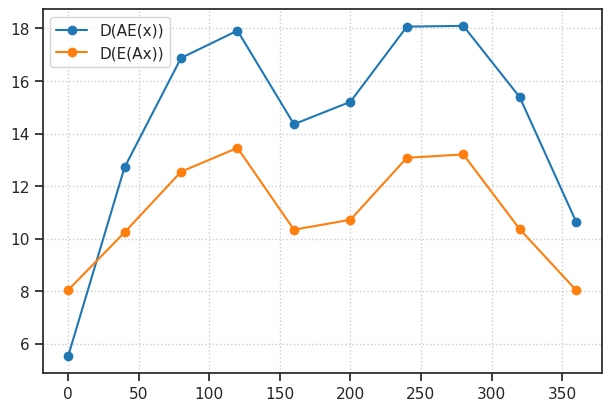

In [57]:
fig, ax = create_figure(1, 1, (6, 4))
ax.plot(loss_rot_recon_vld.keys(), loss_rot_recon_vld.values(), label='D(AE(x))', color='C0', marker='o')
ax.plot(loss_recon_vld.keys(), loss_recon_vld.values(), label='D(E(Ax))', color='C1', marker='o')
add_legend(ax)
add_grid(ax)
plt.show()

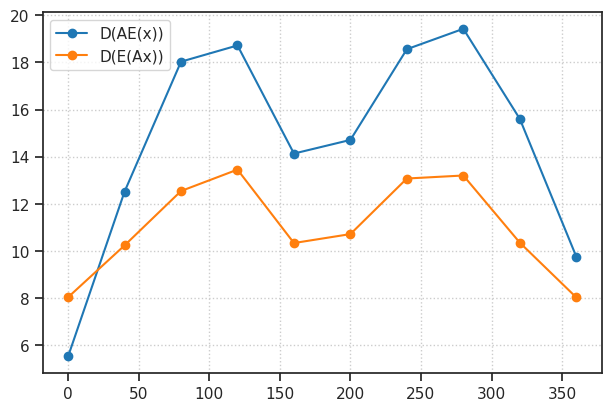

In [31]:
## Was: delta_theta = 40, T = 30

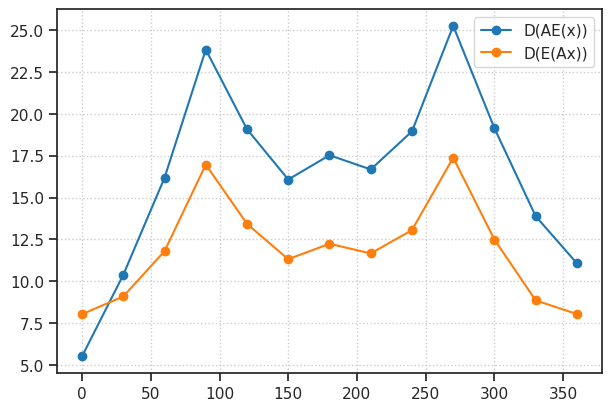

In [33]:
## Was: spacing = 30

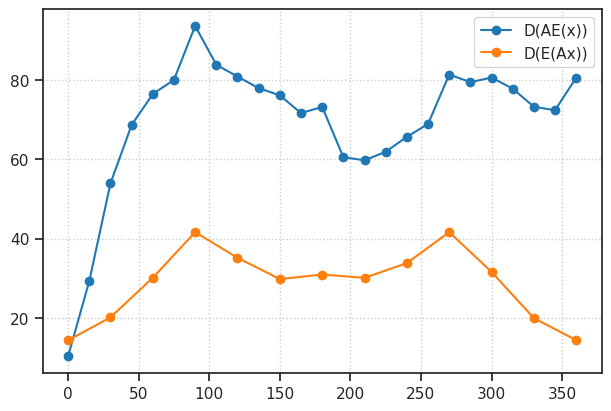

In [40]:
## Was: amortized Gaussian

original:

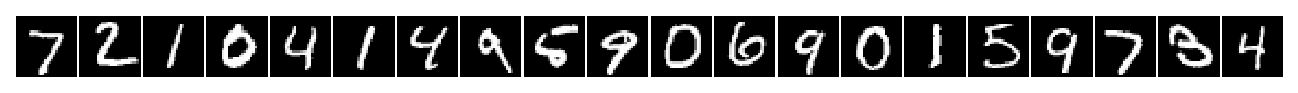

______________________________________________________________________________________________________________

0

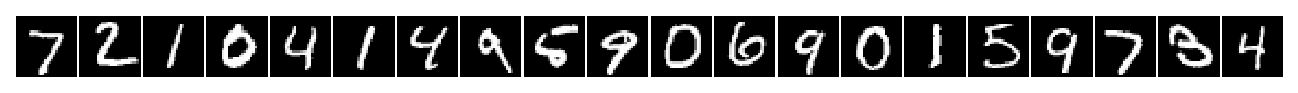

30

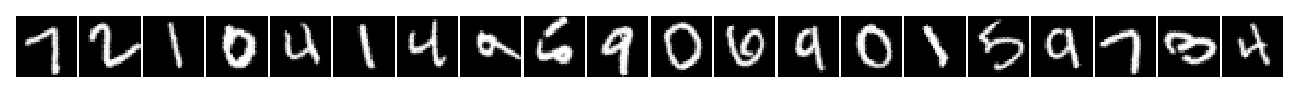

60

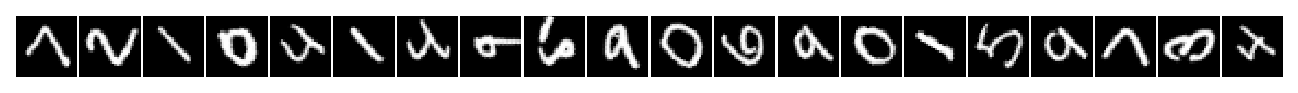

90

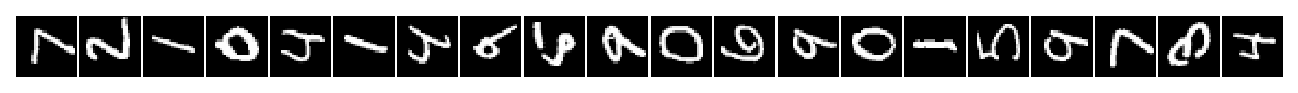

120

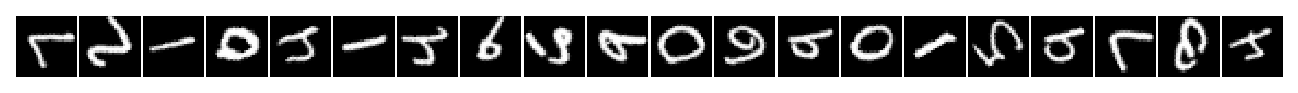

150

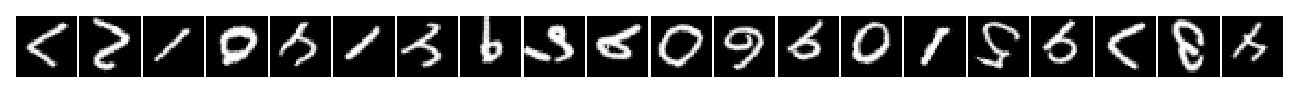

180

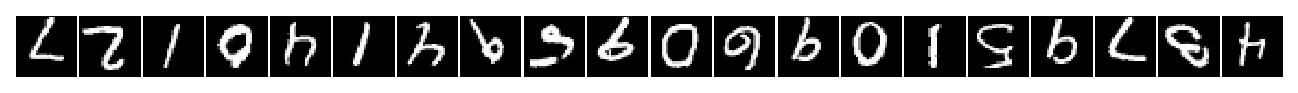

210

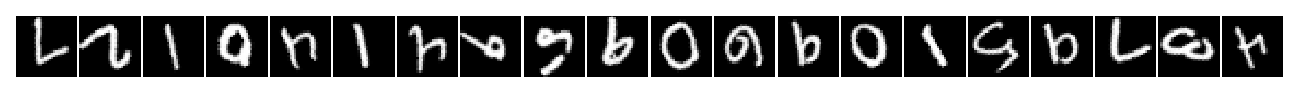

240

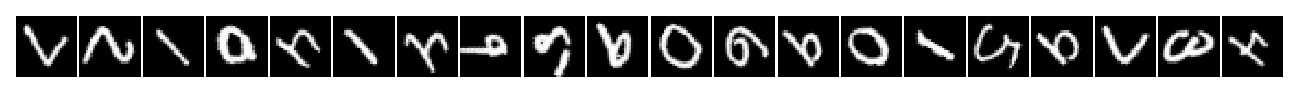

270

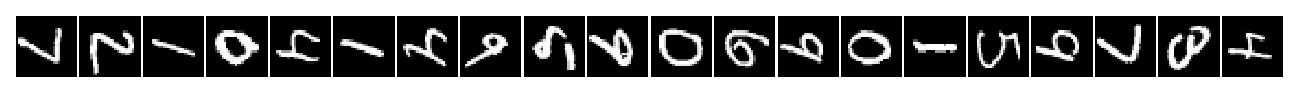

300

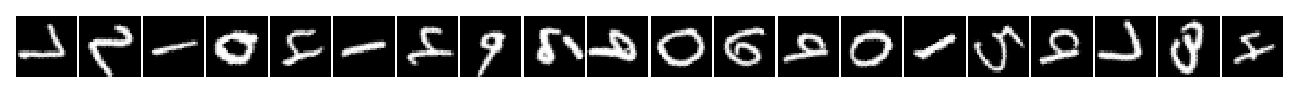

330

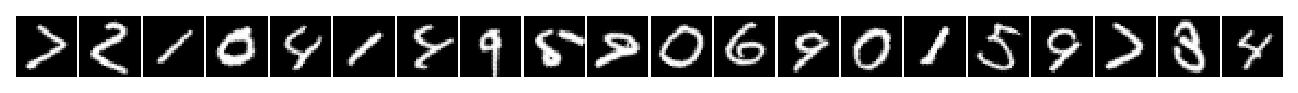

360

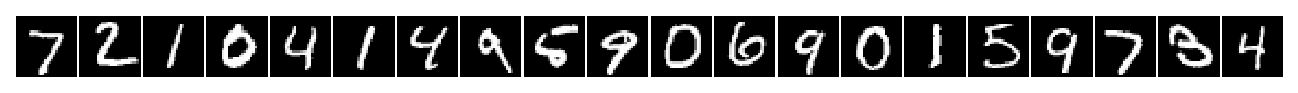

In [41]:
x = next(iter(tr.dl_vld))[0]
print('original:')
_ = plot_weights(tonp(x[:20, 0]), nrows=1)
print('_' * 110)

for theta, x_rot in x_rot_vld.items():
    print(theta)
    _ = plot_weights(tonp(x_rot[0][:20, 0]), nrows=1)

In [65]:
x = next(iter(tr.dl_vld))[0]
output = tr.model.xtract_ftr(x, seq=range(100))
output = output.stack()

print(tr.model.layer.n_updates)

100

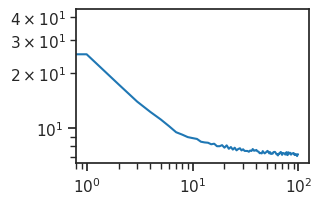

In [66]:
plt.loglog(tonp(output['loss_recon'].mean(0)));